# Load modules

In [1]:
%load_ext autoreload
%autoreload 2

import pathlib
import warnings

# 
import numpy as np  # matrix algebra
import pandas as pd  # dataframes
import matplotlib as mpl
import matplotlib.pyplot as plt  # plotting

import anndata as ad
import scanpy as sc # single cell data library
import muon as mu

from jones_helper_functions import rotate_labels

## settings and global variables
warnings.filterwarnings('ignore')  # looks cleaner but use with caution/never for development

# paths
PATH_PROJ_DIR = pathlib.Path(".")  # project directory
PATH_FIG_DIR = PATH_PROJ_DIR / f"figures/stankiewicz-michaels_processing"
PATH_DATA_DIR = PATH_PROJ_DIR / f"data"
pathlib.Path(PATH_FIG_DIR).mkdir(parents=True, exist_ok=True)  # make dirs if they dont exist

FIG_TYPE = "svg"
DPI_SCALE = 300  # dpi scale for figures
FONT_SIZE = 10  # set font size for figures
sc.settings._file_format_figs = FIG_TYPE
# set scanpy settings
sc.settings.figdir = PATH_FIG_DIR  # set figure directory
# svg format, dpi, transparent background
sc.settings.set_figure_params(format=FIG_TYPE, dpi=DPI_SCALE, transparent=True, fontsize=FONT_SIZE)

# export matplotlib as svgs
# Set the global default figure size
plt.rcParams["figure.figsize"] = (3, 3)
plt.rcParams["pdf.fonttype"] = 42  # set font type for pdfs
plt.rcParams["ps.fonttype"] = 42  # set font type for postscript files
# plt.rcParams['figure.dpi'] = 600
# plt.rcParams['savefig.dpi'] = 600
# disable grid
mpl.rcParams["axes.grid"] = False  # disable grid in plots
plt.rcParams.update({"font.size": FONT_SIZE})  # set font size for matplotlib


# set random seed for reproducibility
SEED = 82
np.random.seed(SEED)  # set random seed for numpy

c:\Users\jones\.conda\envs\sc-dense\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\jones\.conda\envs\sc-dense\Lib\site-packages\muon\_core\preproc.py:31: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('scanpy')` instead
  if Version(scanpy.__version__) < Version("1.10"):


# Load data

In [2]:
adata = sc.read_h5ad(PATH_DATA_DIR / f"Resequenced_day28_PSC_DPs.h5ad")

# Rename selected cell types
rename_dict = {
    "Cycling DP cells": "DP_P",
    "DP cells": "DP_Q",
    "CD8aa SP cells": "8aa",
    "gdT cells": "gdT",
    "Stimulated DPs": "Myeloid",
    "Innate-2": "ILC_1",
    "Innate-1": "ILC_2",
    "Unknown myeloid cells": "ILC3",
    "NK/ILCs": "NKs",
}

# Create new column with renamed values
adata.obs["cell type"] = adata.obs["cell type"].replace(rename_dict)

# Reorder
desired_order = ["DP_P", "DP_Q", "8aa", "gdT", "Myeloid", "ILC_1", "ILC_2", "ILC3", "NKs"]

# Set the column as an ordered categorical
adata.obs["cell type"] = pd.Categorical(
    adata.obs["cell type"], categories=desired_order, ordered=True
)

mdata = mu.MuData(
    {
        "rna": adata[:, adata.var["feature_types"] == "Gene Expression"],
        "prot": adata[:, ~(adata.var["feature_types"] == "Gene Expression")],
    }
)
mdata

MuData object with n_obs × n_vars = 13825 × 22472
  var:	'gene_ids', 'feature_types', 'n_counts'
  2 modalities
    rna:	13825 x 22335
      obs:	'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'rna_leiden', 'protein_leiden', 'cell type'
      var:	'gene_ids', 'feature_types', 'n_counts'
      uns:	'cell type_colors', 'leiden', 'neighbors', 'pca', 'umap'
      obsm:	'X_pca', 'X_umap', 'protein', 'protein_umap'
      layers:	'counts'
      obsp:	'connectivities', 'distances', 'protein_connectivities', 'rna_connectivities'
    prot:	13825 x 137
      obs:	'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'rna_leiden', 'protein_leiden', 'cell type'
      var:	'gene_ids', 'feature_types', 'n_counts'
      uns:	'cell type_colors', 'leiden', 'neighbors', 'pca', 'umap'
      obsm:	'X_pca', 'X_umap', 'protein', 'protein_umap'
      layers:	'counts'
      obsp:	'connectivities', 'distances', 'protein_connectivities', 'rna_connectivities'

# Analysis

In [19]:
mdata.uns['rna:cell type_colors']

{'DP_P': '#98FB98',
 'DP_Q': '#2CA02C',
 '8aa': '#FF8C00',
 'gdT': '#D62728',
 'Myeloid': '#808080',
 'ILC_1': '#A52A2A',
 'ILC_2': '#D2B48C',
 'ILC3': '#8B4513',
 'NKs': '#B8860B'}

In [15]:
colors = {
    "DP_P": "#98FB98",  # 152 251 152
    "DP_Q": "#2CA02C",  # 44 160 44
    "8aa": "#FF8C00",   # 255 140 0
    "gdT": "#D62728",   # 214 39 40
    "Myeloid": "#808080",  # 128 128 128
    "ILC_1": "#A52A2A",  # 165 42 42
    "ILC_2": "#D2B48C",  # 210 180 140
    "ILC3": "#8B4513",   # 139 69 19
    "NKs": "#B8860B",    # 184 134 11
}

# also set top-level / prefixed keys that mu/scanpy may look for
mdata.uns["rna:cell type_colors"] = colors
mdata.uns["prot:cell type_colors"] = colors

# keep adata in sync (rna AnnData)
adata.uns["cell type_colors"] = colors

## Dimensional reduction

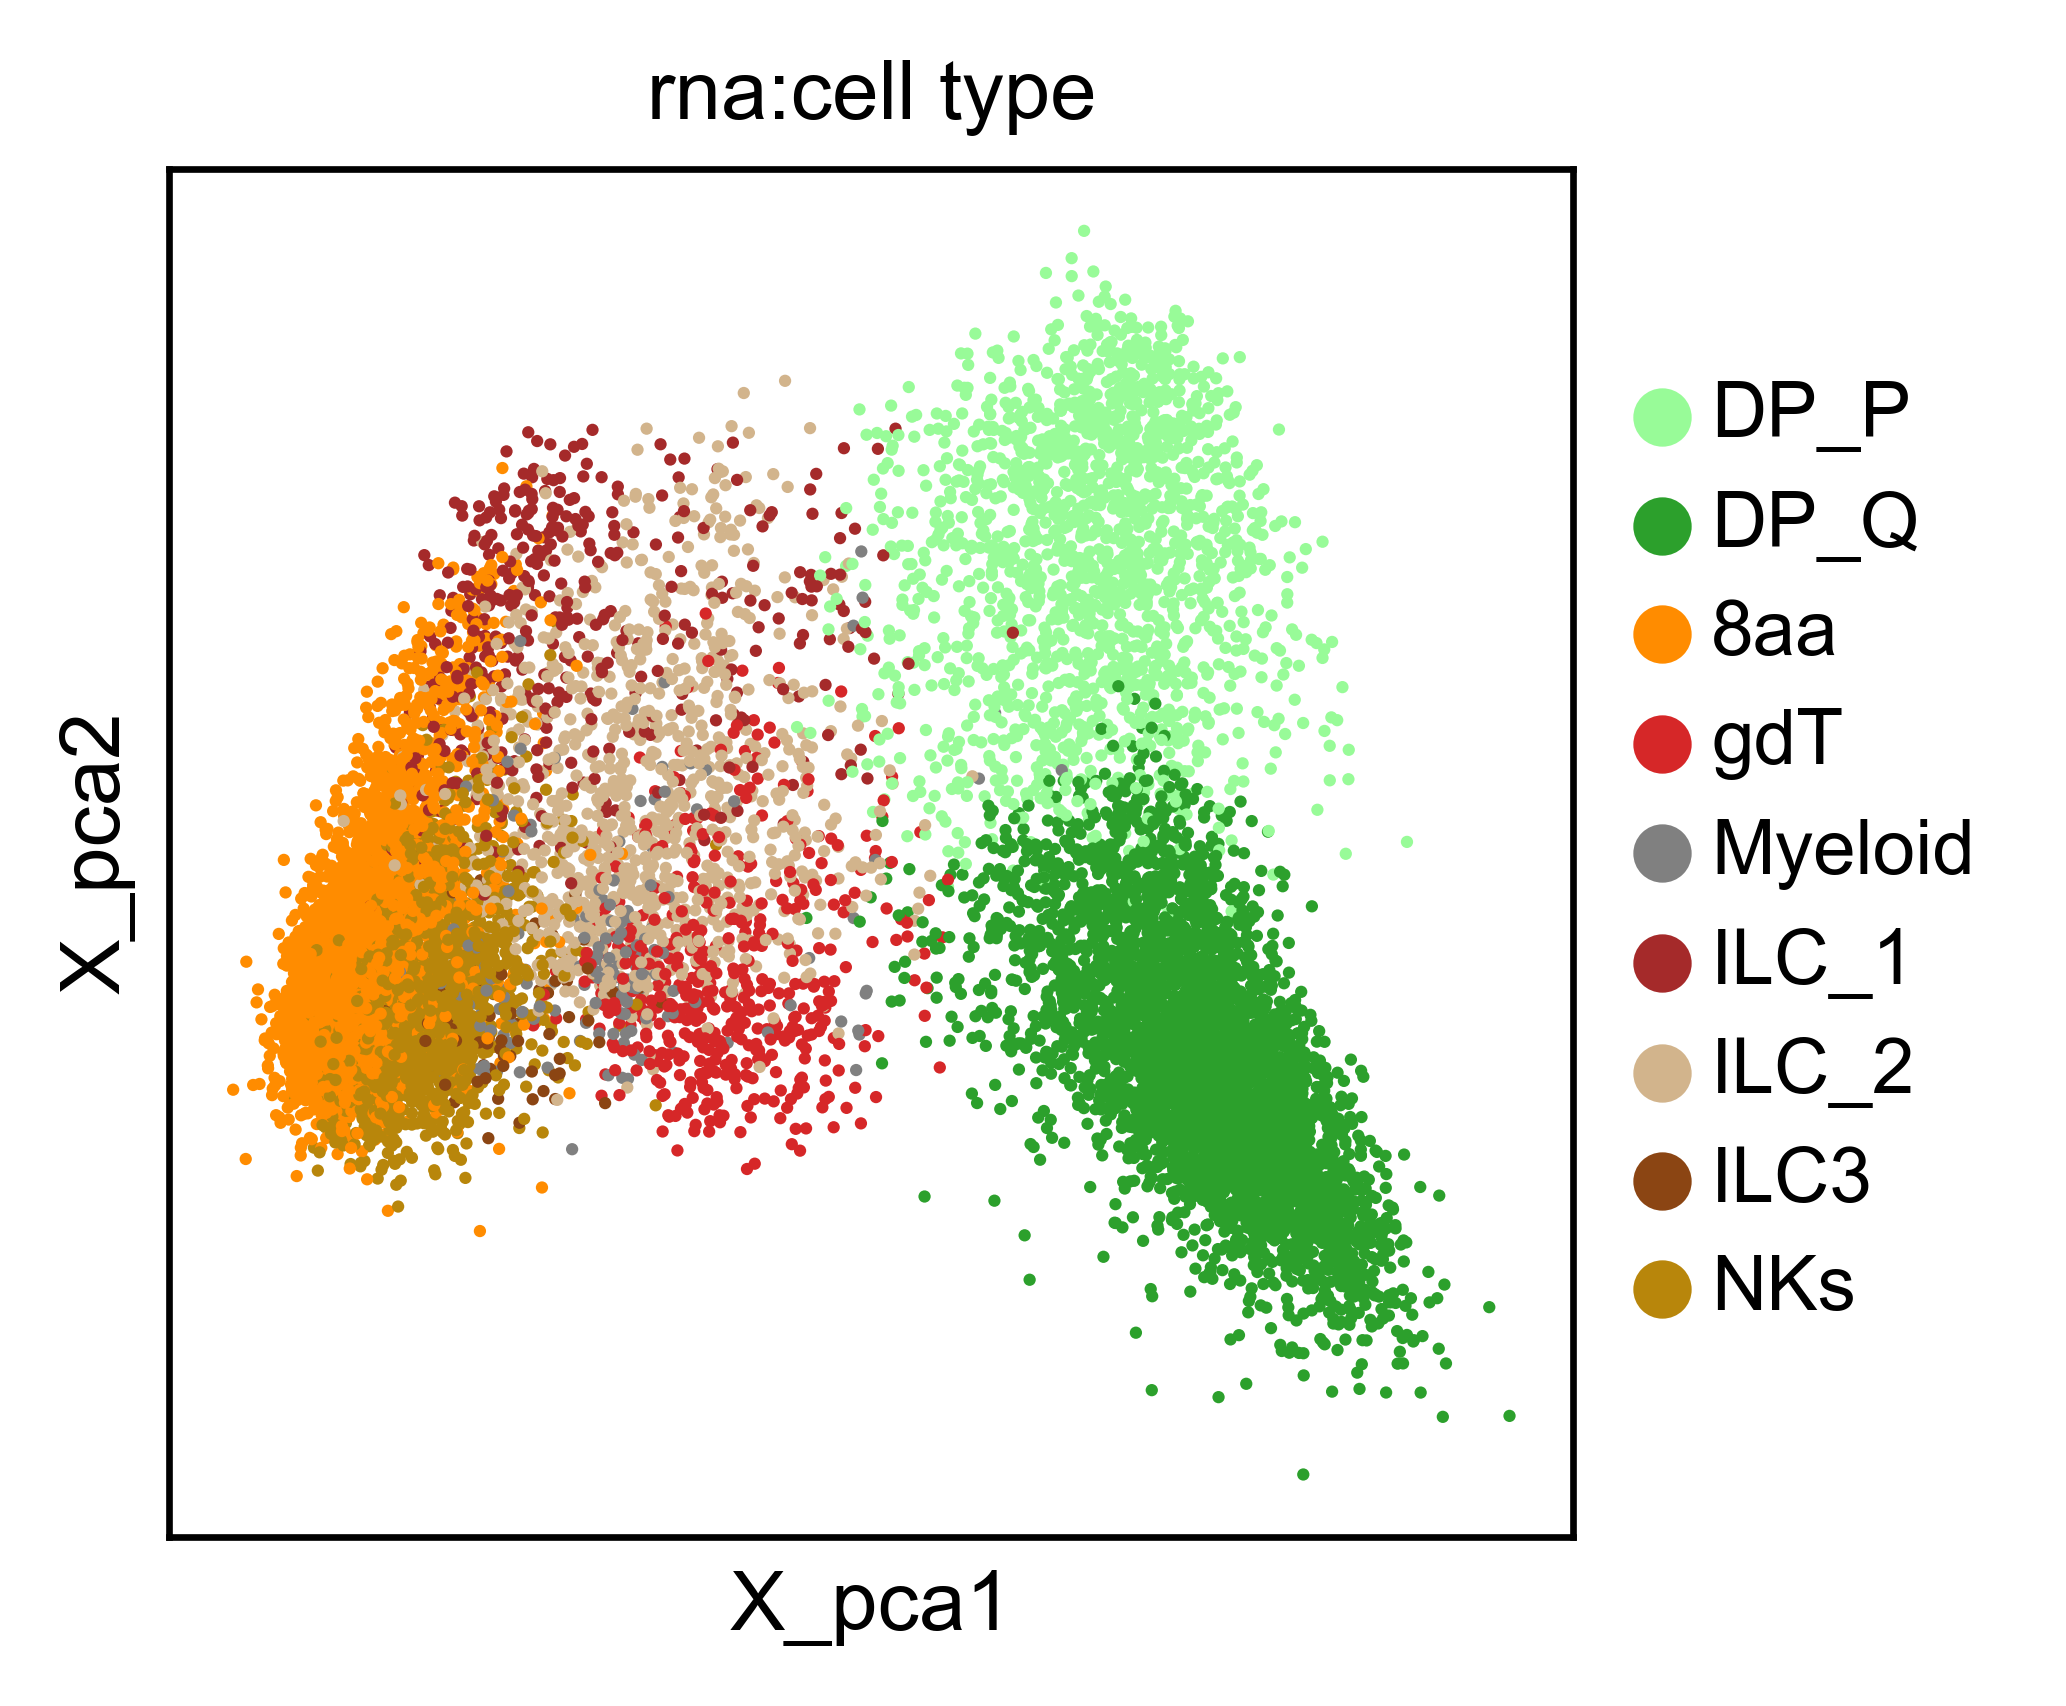

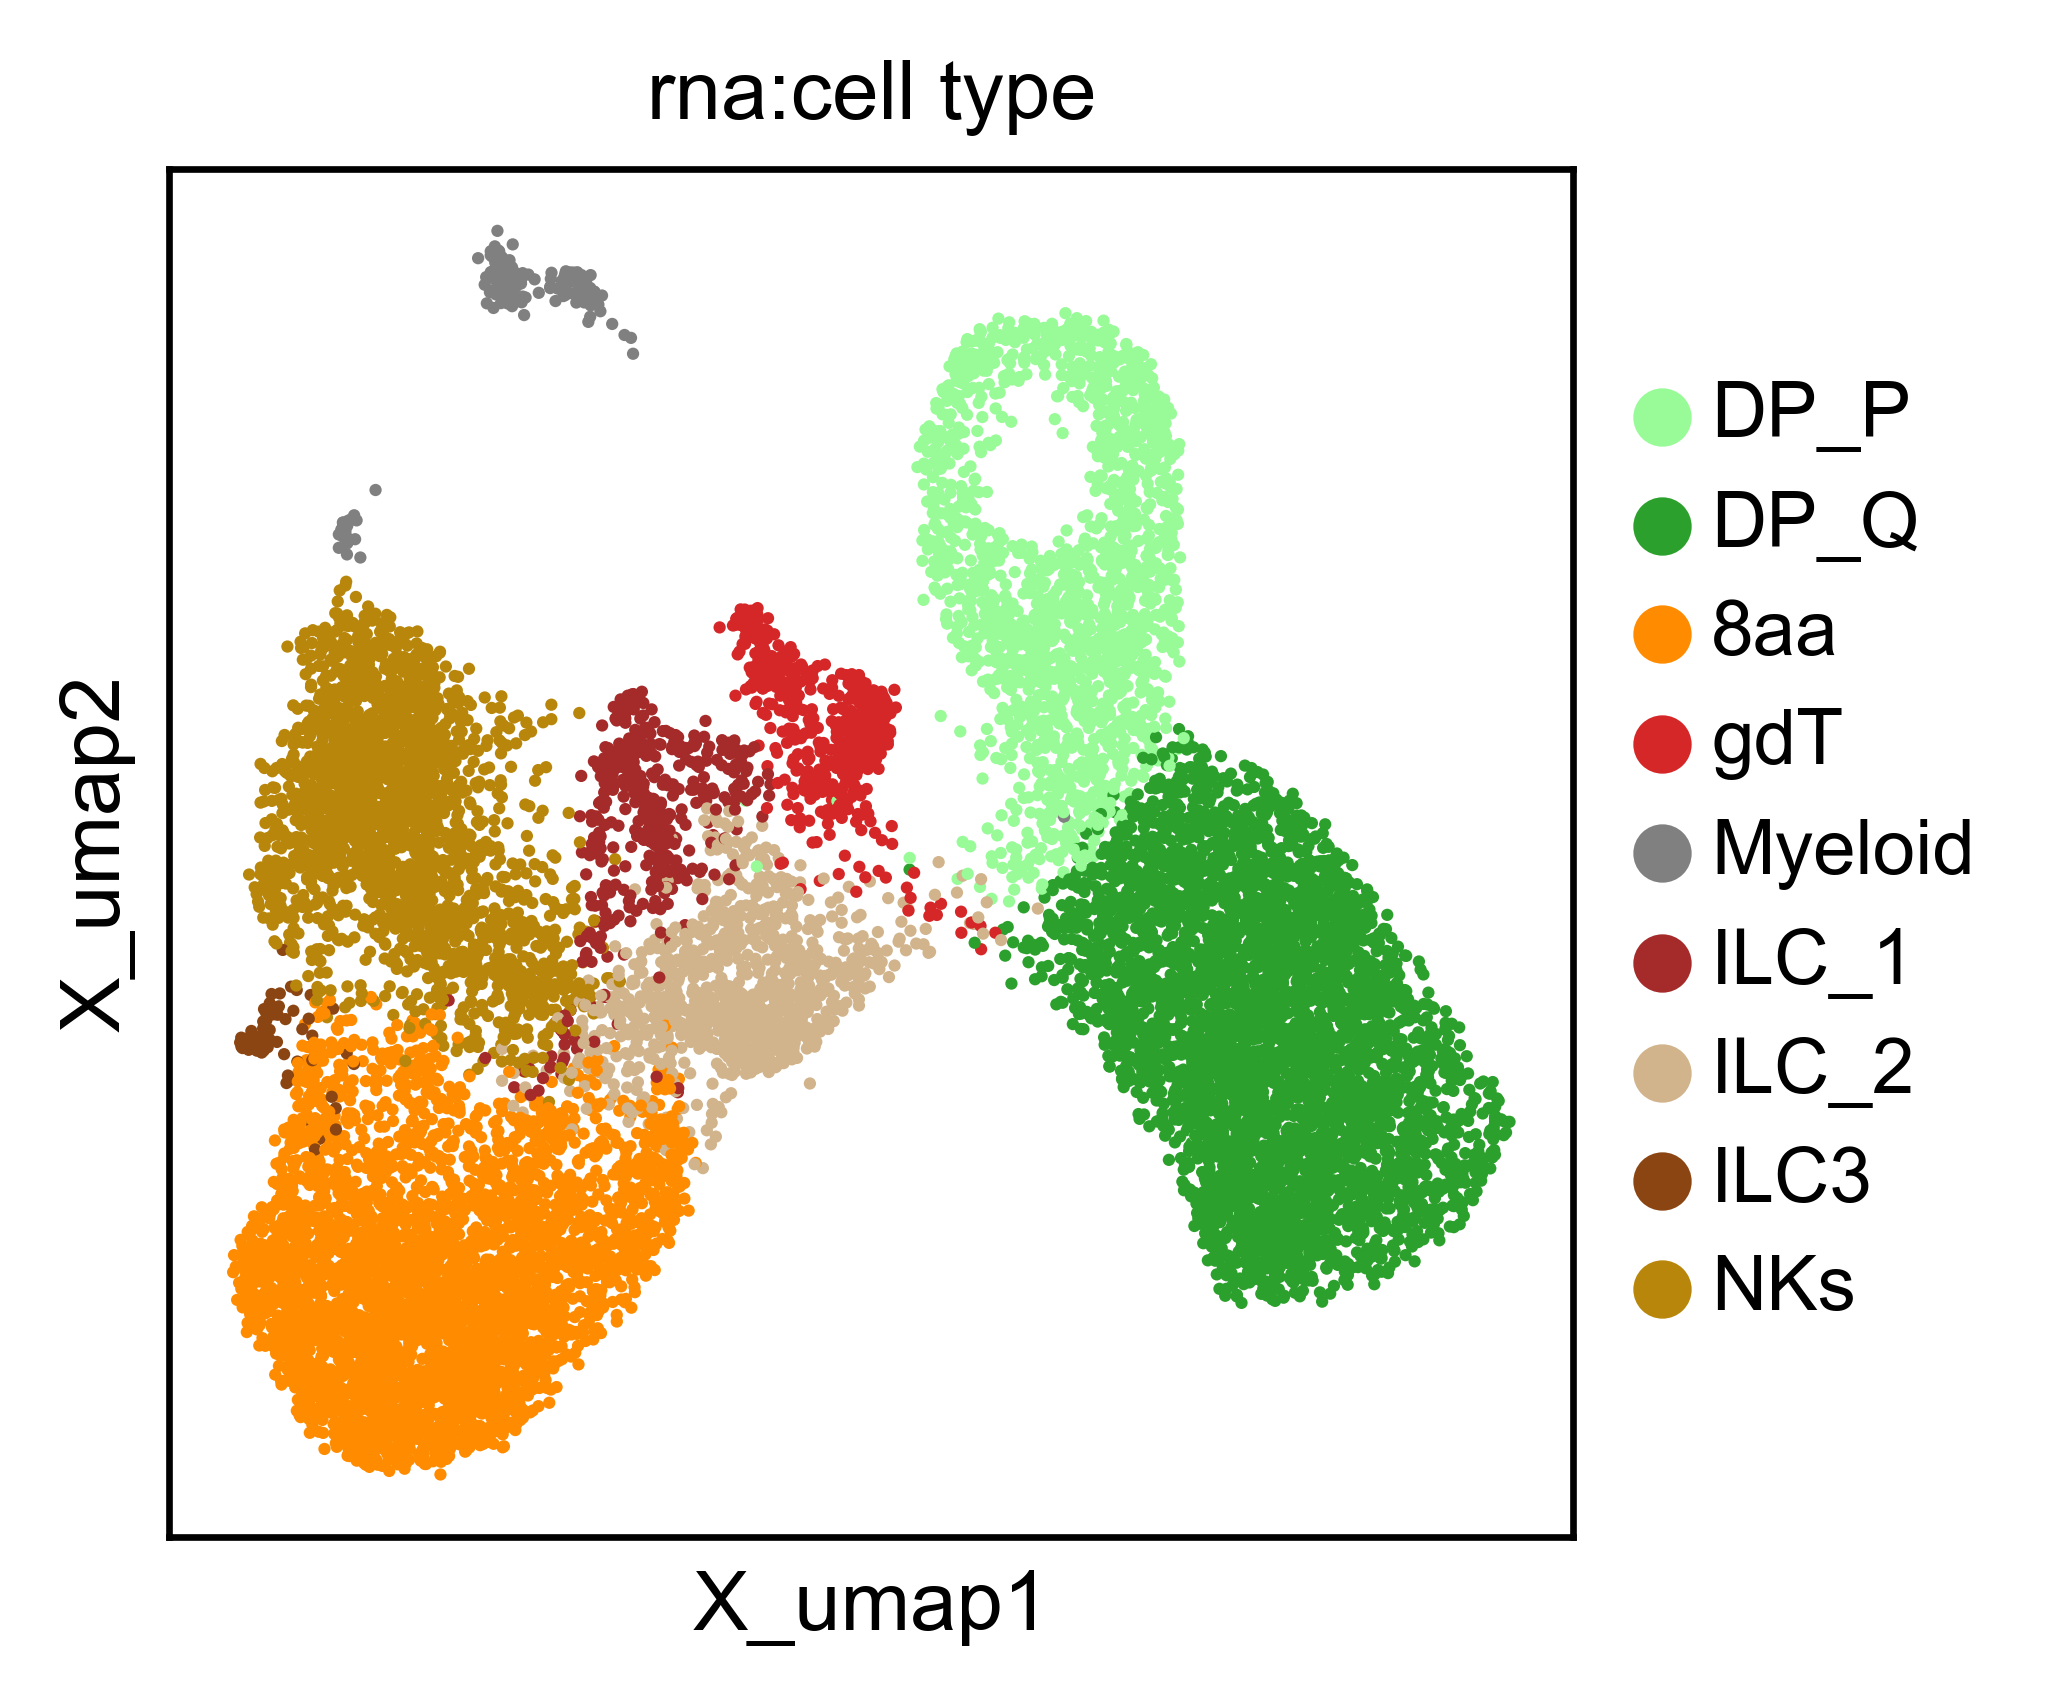

In [21]:
mu.pl.embedding(mdata, basis="rna:X_pca", color=["rna:cell type"], palette=colors)
mu.pl.embedding(mdata, basis="rna:X_umap", color=["rna:cell type"], palette=colors)

## Dotplots (Exploratory)

In [7]:
adata.var_names[adata.var_names.str.contains("anti-human_TRBC1")]

Index([], dtype='object')

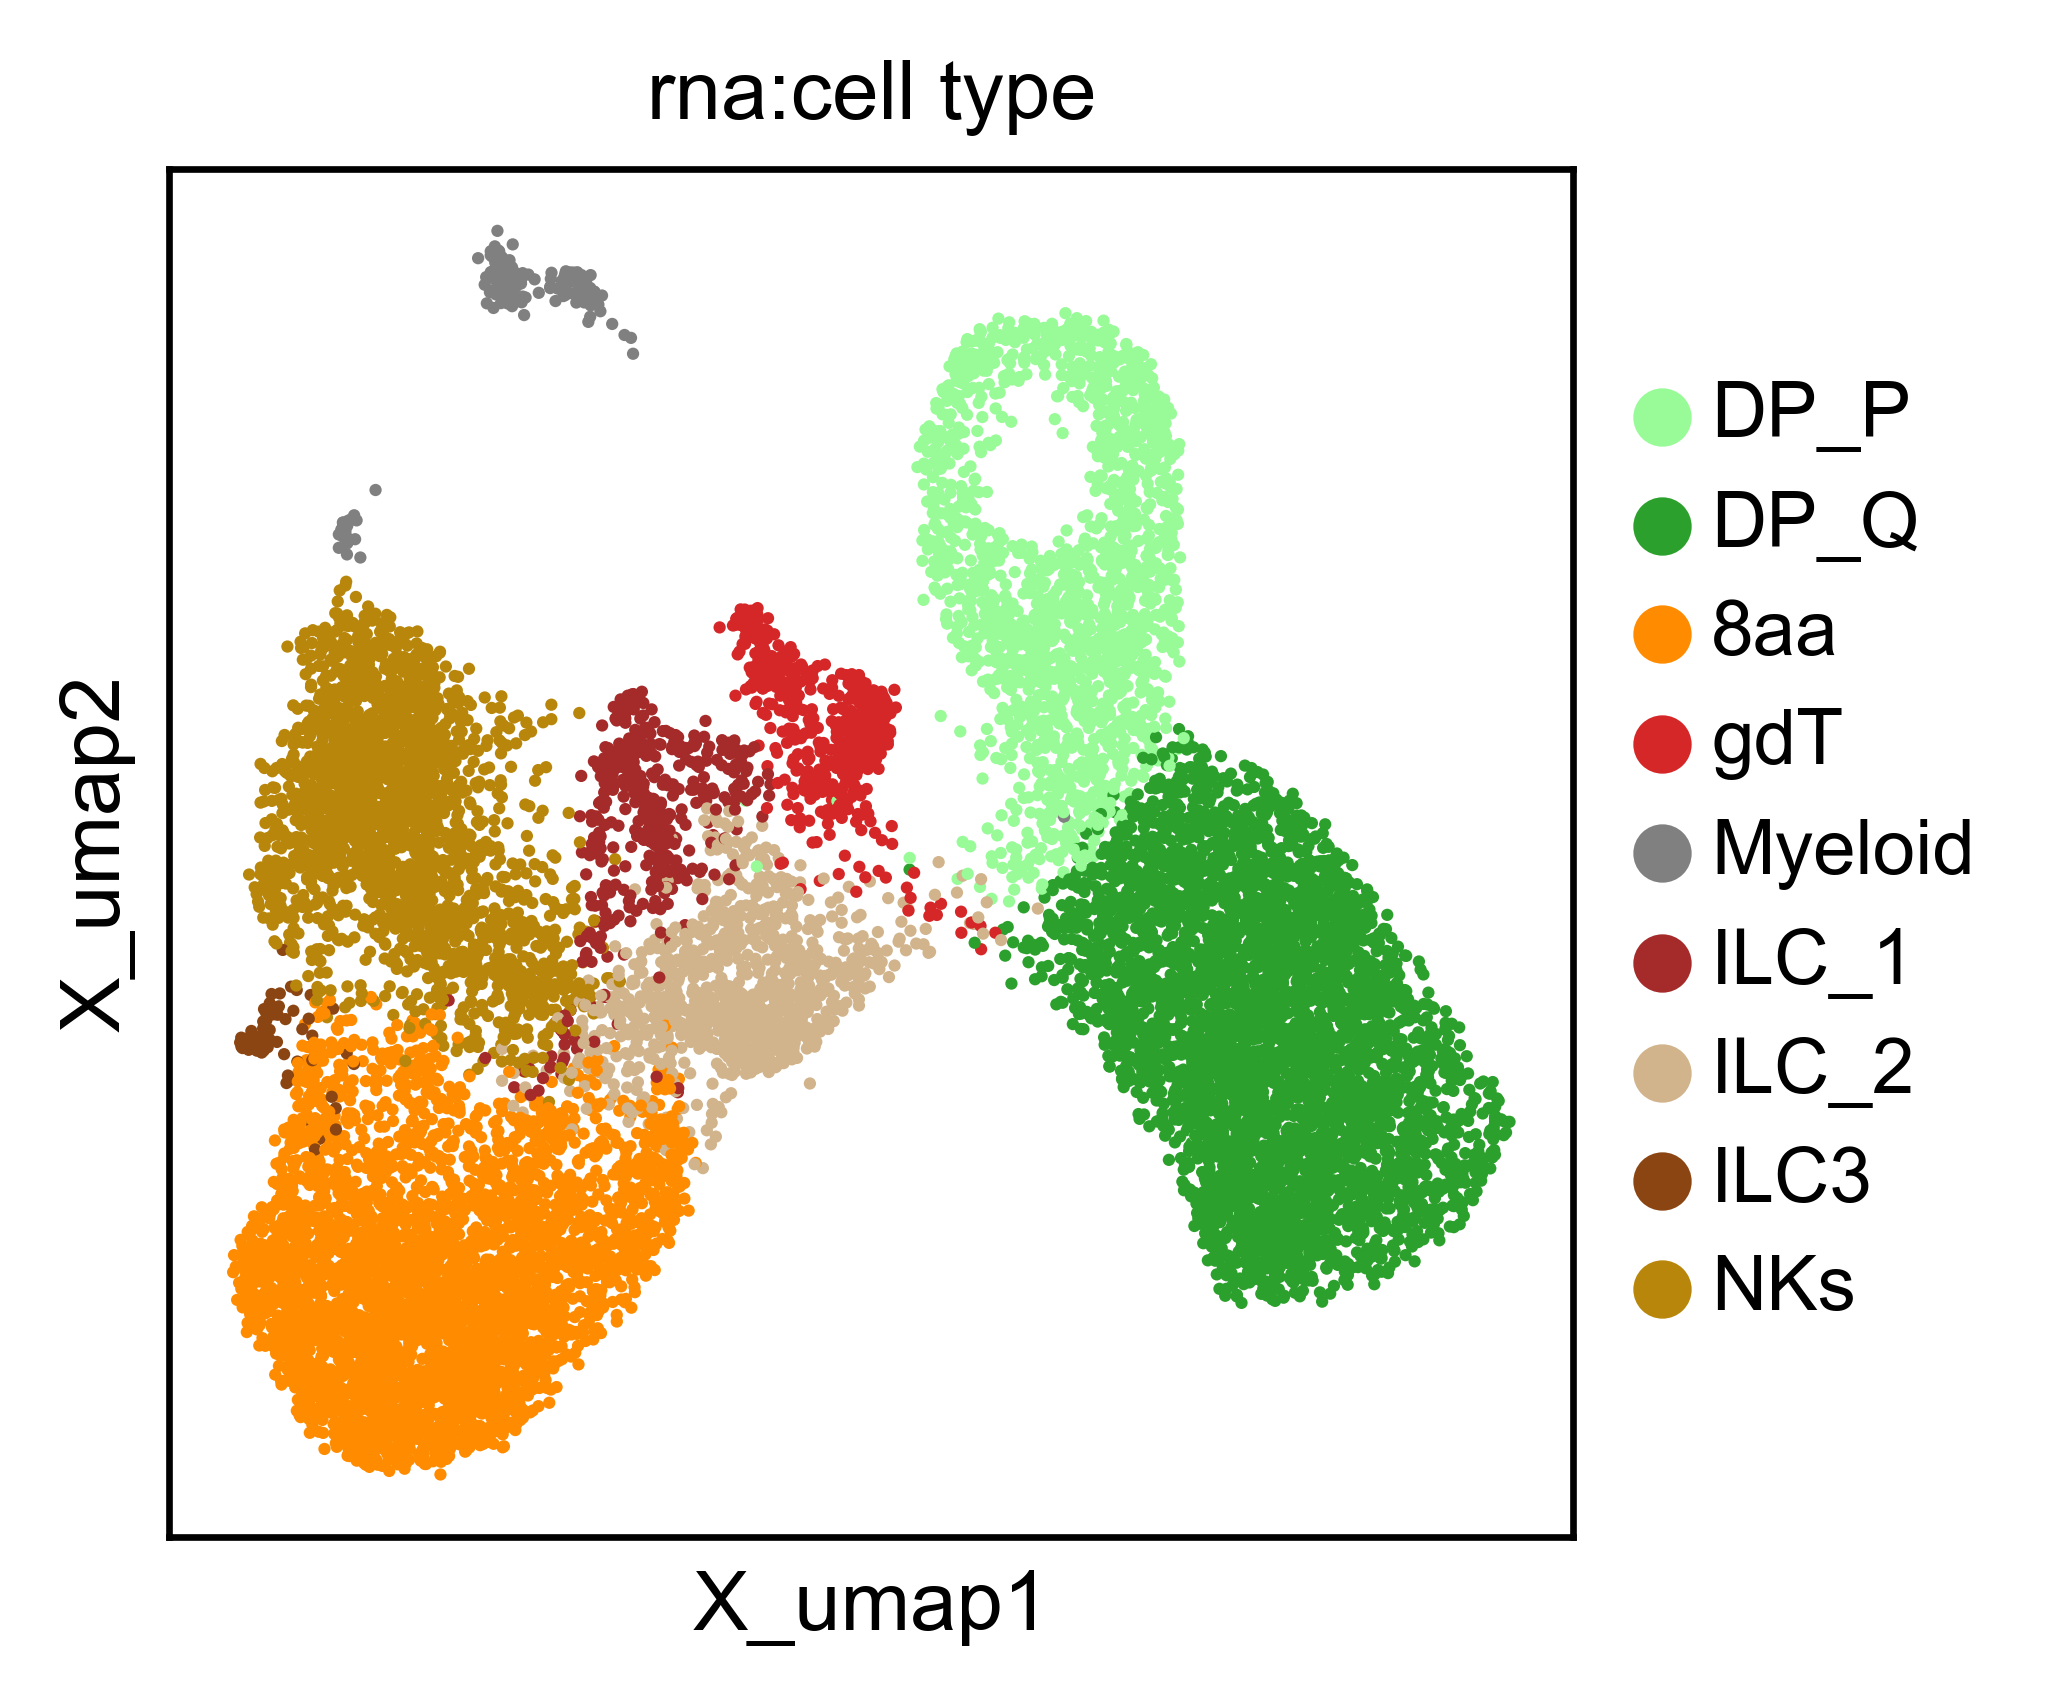

categories: DP_P, DP_Q, 8aa, etc.
var_group_labels: Cytotoxic/Inflammatory 


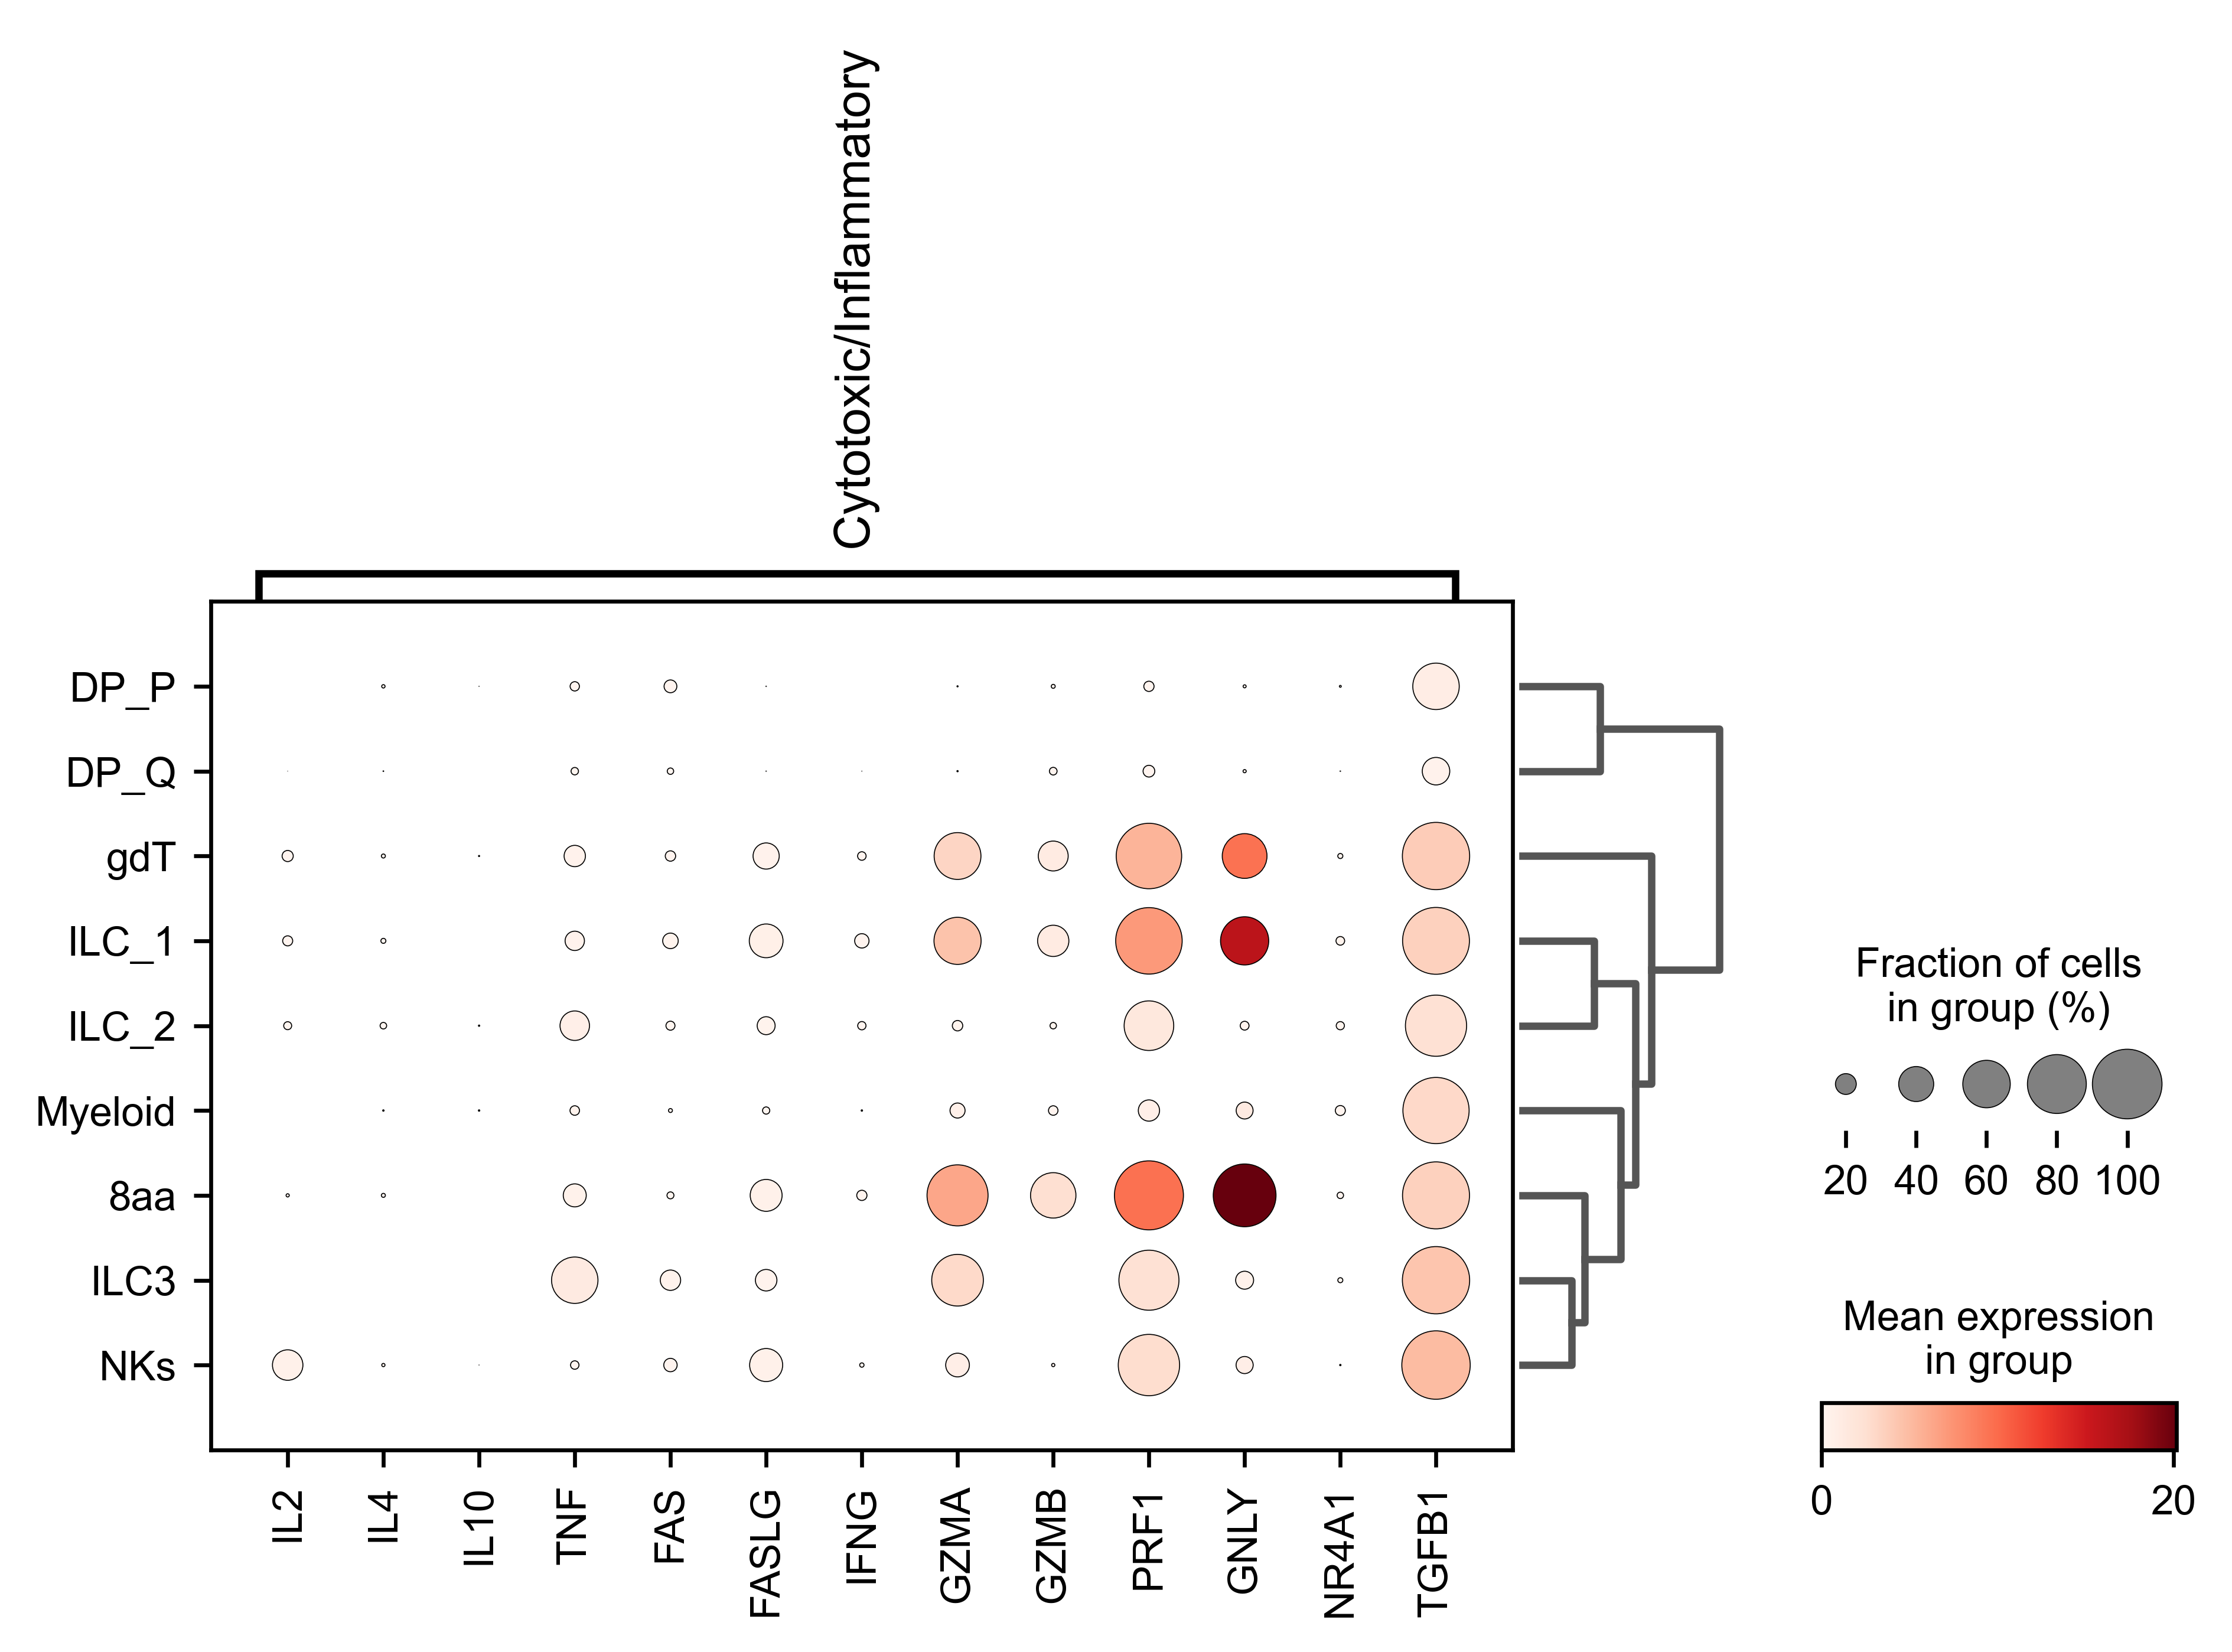

categories: DP_P, DP_Q, 8aa, etc.
var_group_labels: T-cell, Cytotoxic/Inflammatory , TCR, etc.


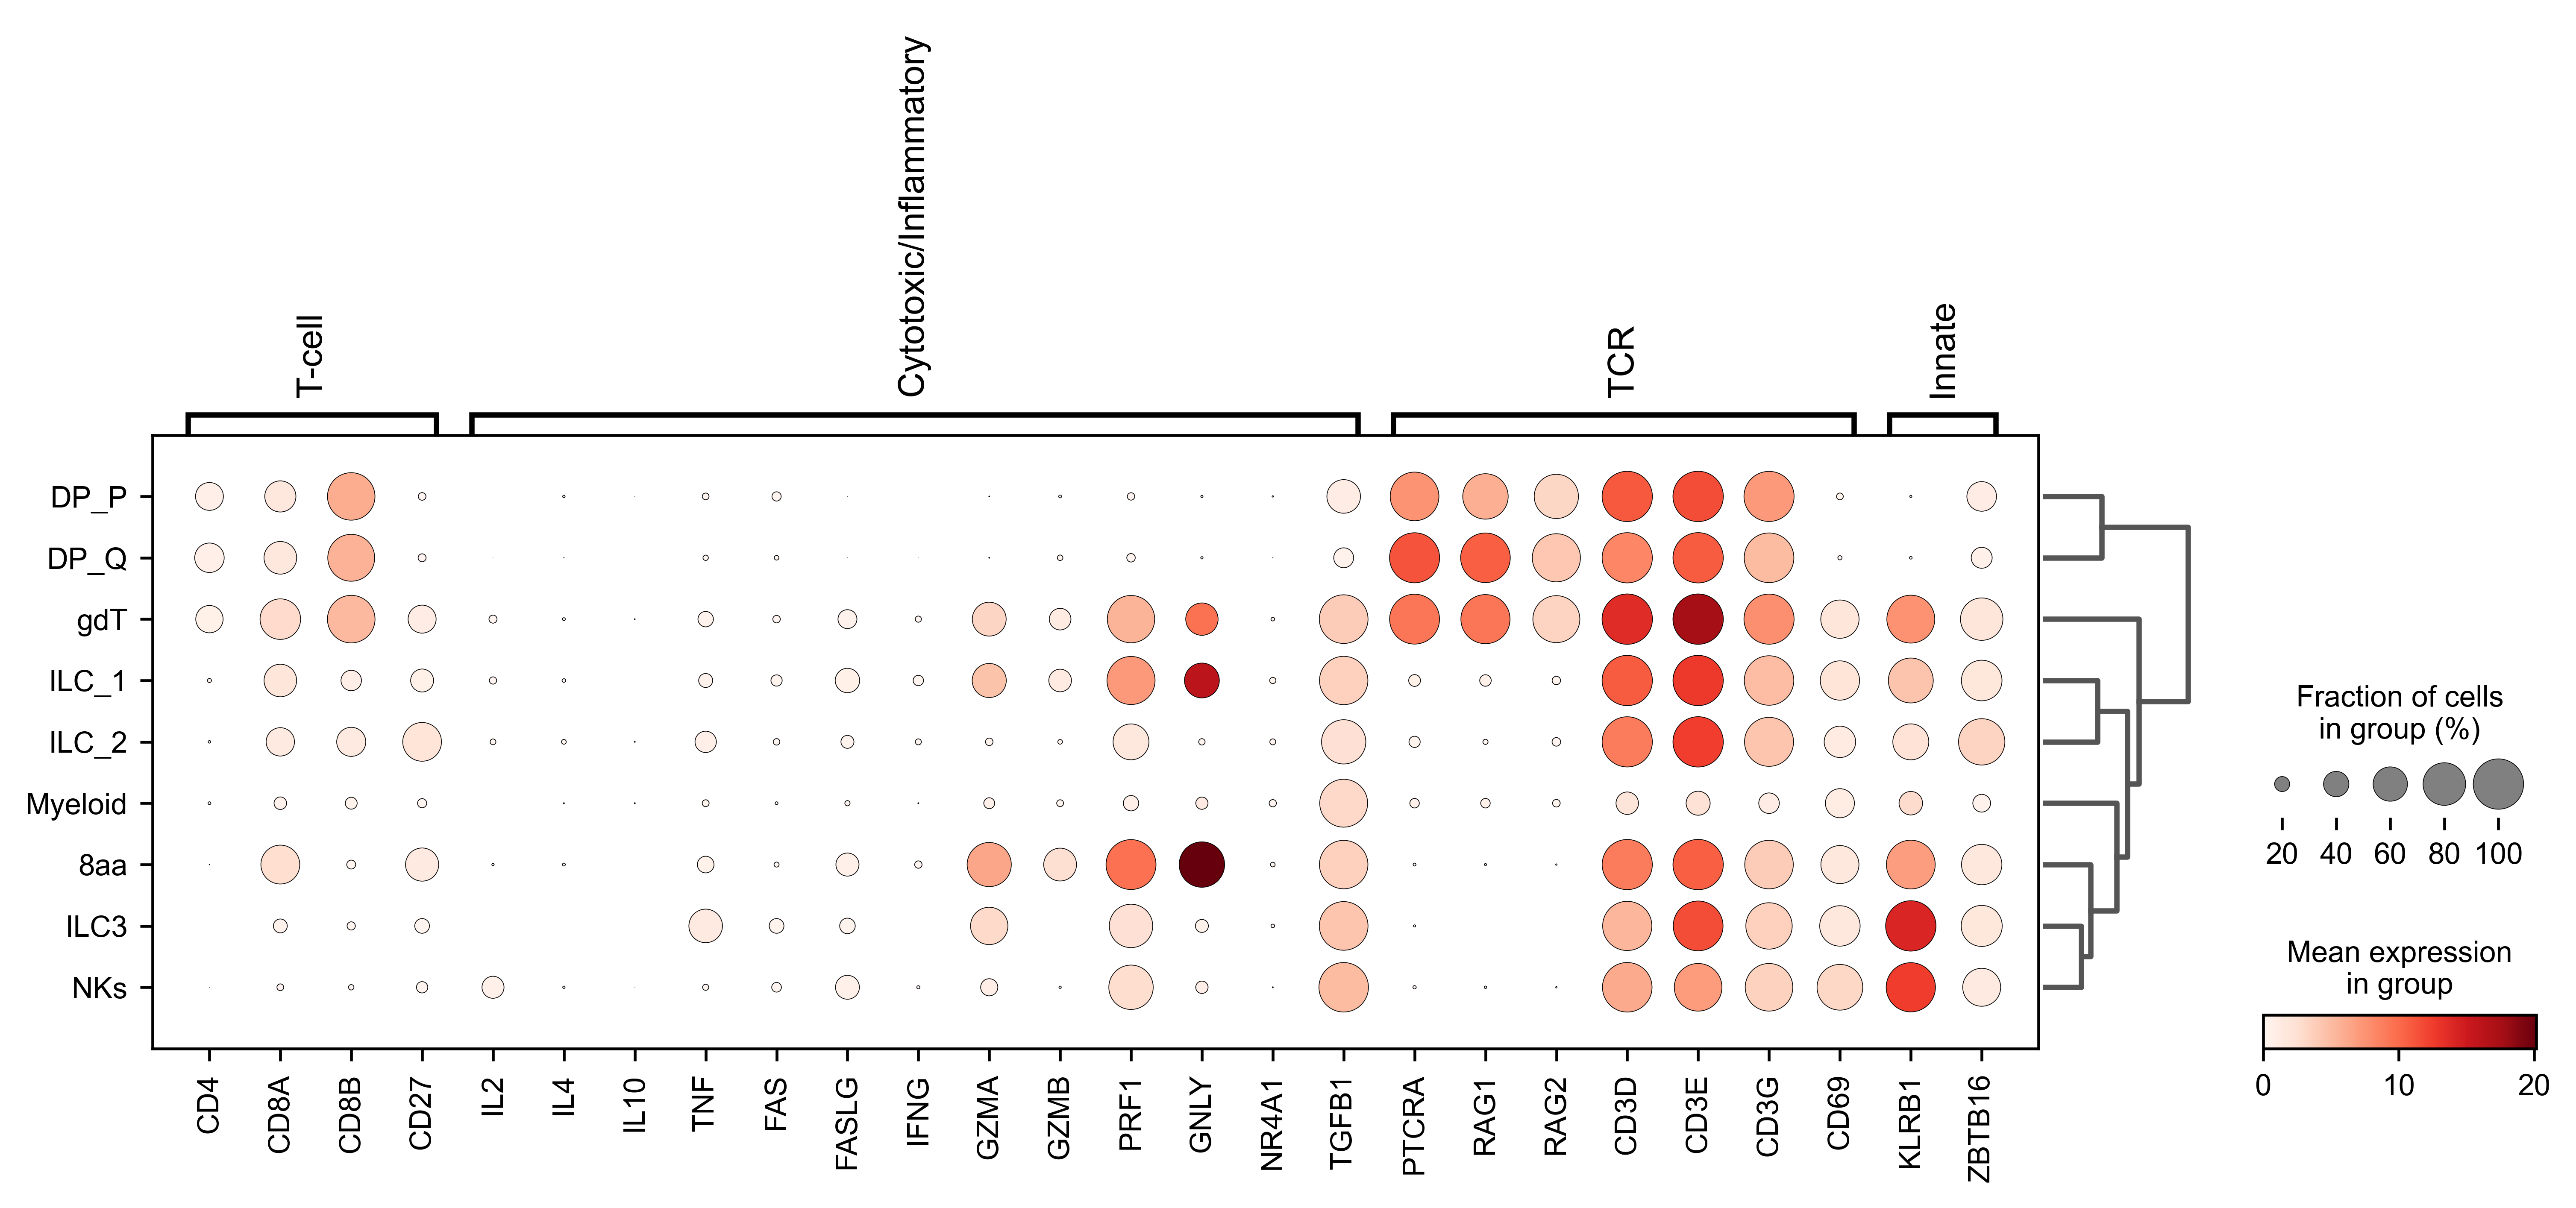

categories: DP_P, DP_Q, 8aa, etc.
var_group_labels: Apoptosis, Selection


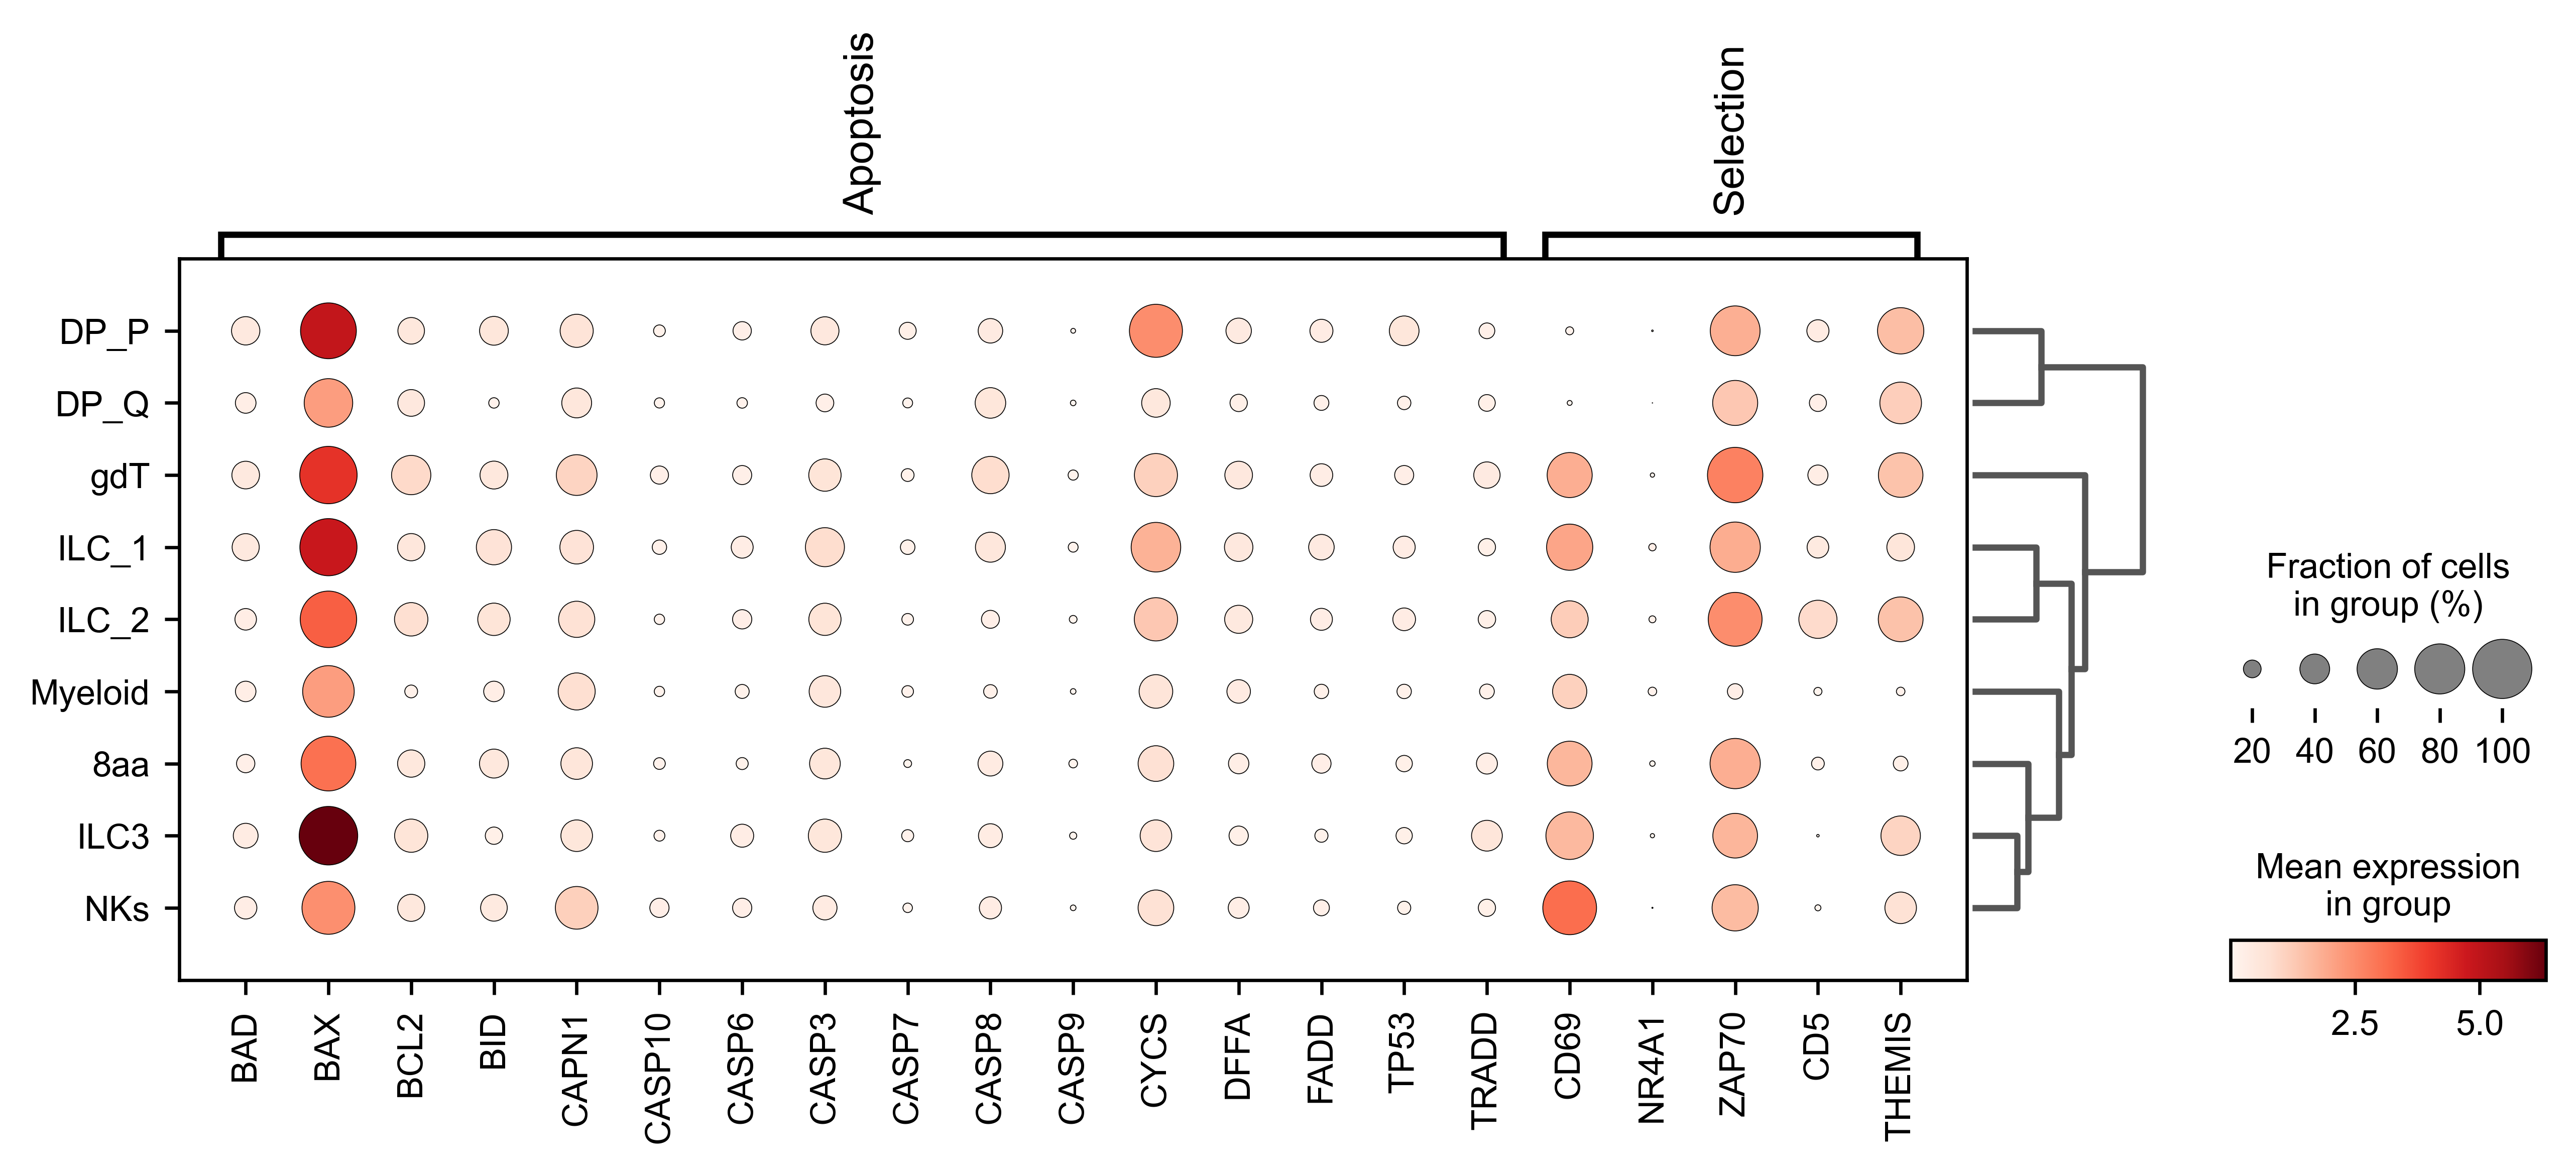

In [22]:
voi = {
    "T-cell": ["CD4", "CD8A", "CD8B", "CD27"],
    "Cytotoxic/Inflammatory ": [
        "IL2",
        "IL4",
        "IL10",
        "TNF",
        "FAS",
        "FASLG",
        "IFNG",
        "GZMA",
        "GZMB",
        "PRF1",
        "GNLY",
        "NR4A1",
        "TGFB1",
    ],
    "TCR": [
        "PTCRA",
        "RAG1",
        "RAG2",
        "CD3D",
        "CD3E",
        "CD3G",
        "CD69",
    ],
    "Innate": ["KLRB1", "ZBTB16"],
}

voi_inflam = {
    "Cytotoxic/Inflammatory ": [
        "IL2",
        "IL4",
        "IL10",
        "TNF",
        "FAS",
        "FASLG",
        "IFNG",
        "GZMA",
        "GZMB",
        "PRF1",
        "GNLY",
        "NR4A1",
        "TGFB1",
    ]
}

voi_apoptosis = {
    "Apoptosis": [
        "BAD",
        "BAX",
        "BCL2",
        "BID",
        "CAPN1",
        "CASP10",
        "CASP6",
        "CASP3",
        "CASP7",
        "CASP8",
        "CASP9",
        "CYCS",
        "DFFA",
        "FADD",
        "TP53",
        "TRADD",
    ],
    "Selection": ["CD69", "NR4A1", "ZAP70", "CD5", "THEMIS"],
}

mu.pl.embedding(
    mdata, basis="rna:X_umap", color=["rna:cell type"], save=f"_citeseq_celltypes.svg"
)
sc.pl.dotplot(
    adata,
    var_names=voi_inflam,
    groupby="cell type",
    dendrogram=True,
    save=f"_citeseq_celltypes-cytotoxic.svg",
)
sc.pl.dotplot(
    adata,
    var_names=voi,
    groupby="cell type",
    dendrogram=True,
    save=f"_citeseq_celltypes.svg",
)
sc.pl.dotplot(
    adata,
    var_names=voi_apoptosis,
    groupby="cell type",
    dendrogram=True,
    save=f"_citeseq_celltypes-apoptosis.svg",
)

# Ross-Salim Revisions

## Subset DPs, 8aa, and gdT

In [23]:
# Subset to cells that have a renamed label (exclude unrenamed types)
subset_labels = list(rename_dict.values())
adata_subset = adata[adata.obs["cell type"].isin(subset_labels)].copy()

# order
# Desired order (case-sensitive — make sure it matches exactly)
desired_order = ["DP_P", "DP_Q", "8aa", "gdT"]

# Set the column as an ordered categorical
adata_subset.obs["cell type"] = pd.Categorical(
    adata_subset.obs["cell type"], categories=desired_order, ordered=True
)
adata_subset

AnnData object with n_obs × n_vars = 13825 × 22472
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'rna_leiden', 'protein_leiden', 'cell type'
    var: 'gene_ids', 'feature_types', 'n_counts'
    uns: 'cell type_colors', 'leiden', 'neighbors', 'pca', 'umap', 'dendrogram_cell type'
    obsm: 'X_pca', 'X_umap', 'protein', 'protein_umap'
    layers: 'counts'
    obsp: 'connectivities', 'distances', 'protein_connectivities', 'rna_connectivities'

In [4]:
# adata_subset.var_names[adata_subset.var_names.str.contains("anti-human_CD8")]
adata_subset.var_names[adata_subset.var_names.str.contains("TCR")]

Index(['PTCRA', 'anti-human_TCR', 'anti-human_TCR_V_7_2',
       'anti-human_TCR_V_2'],
      dtype='object')

## Dotplots

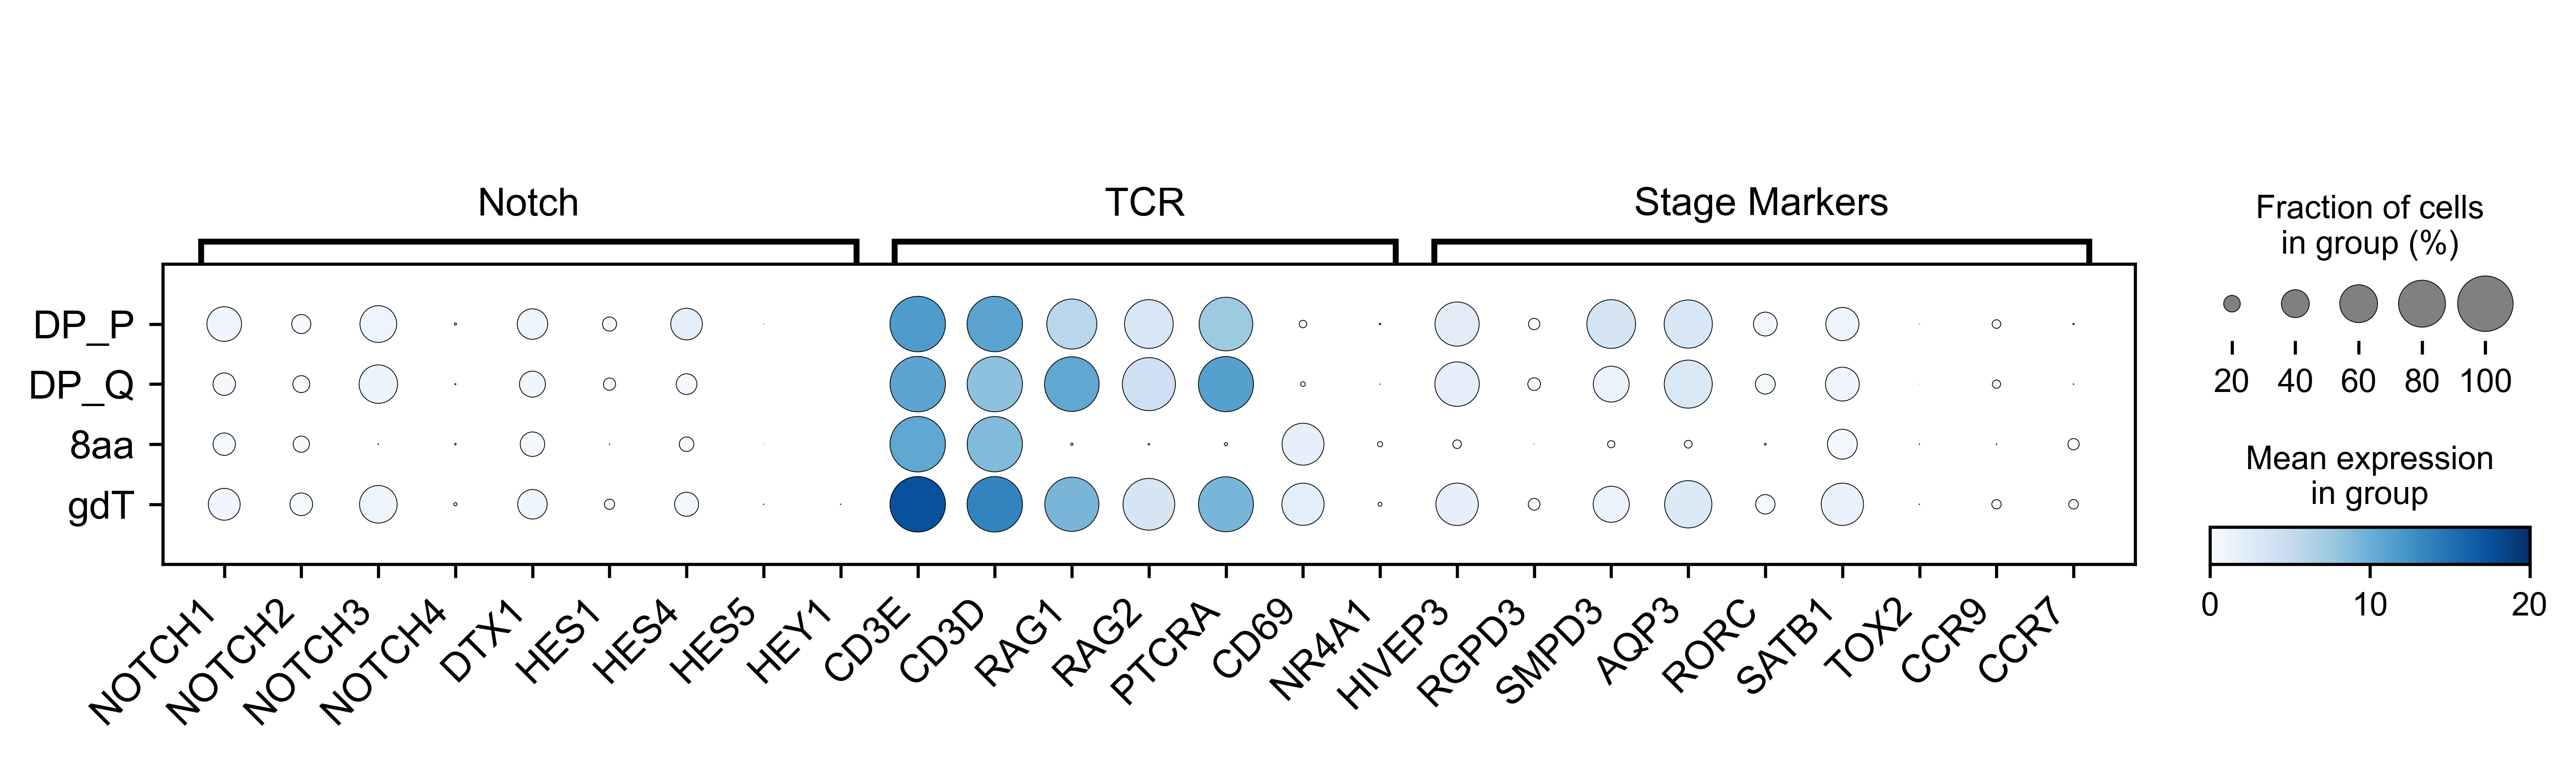

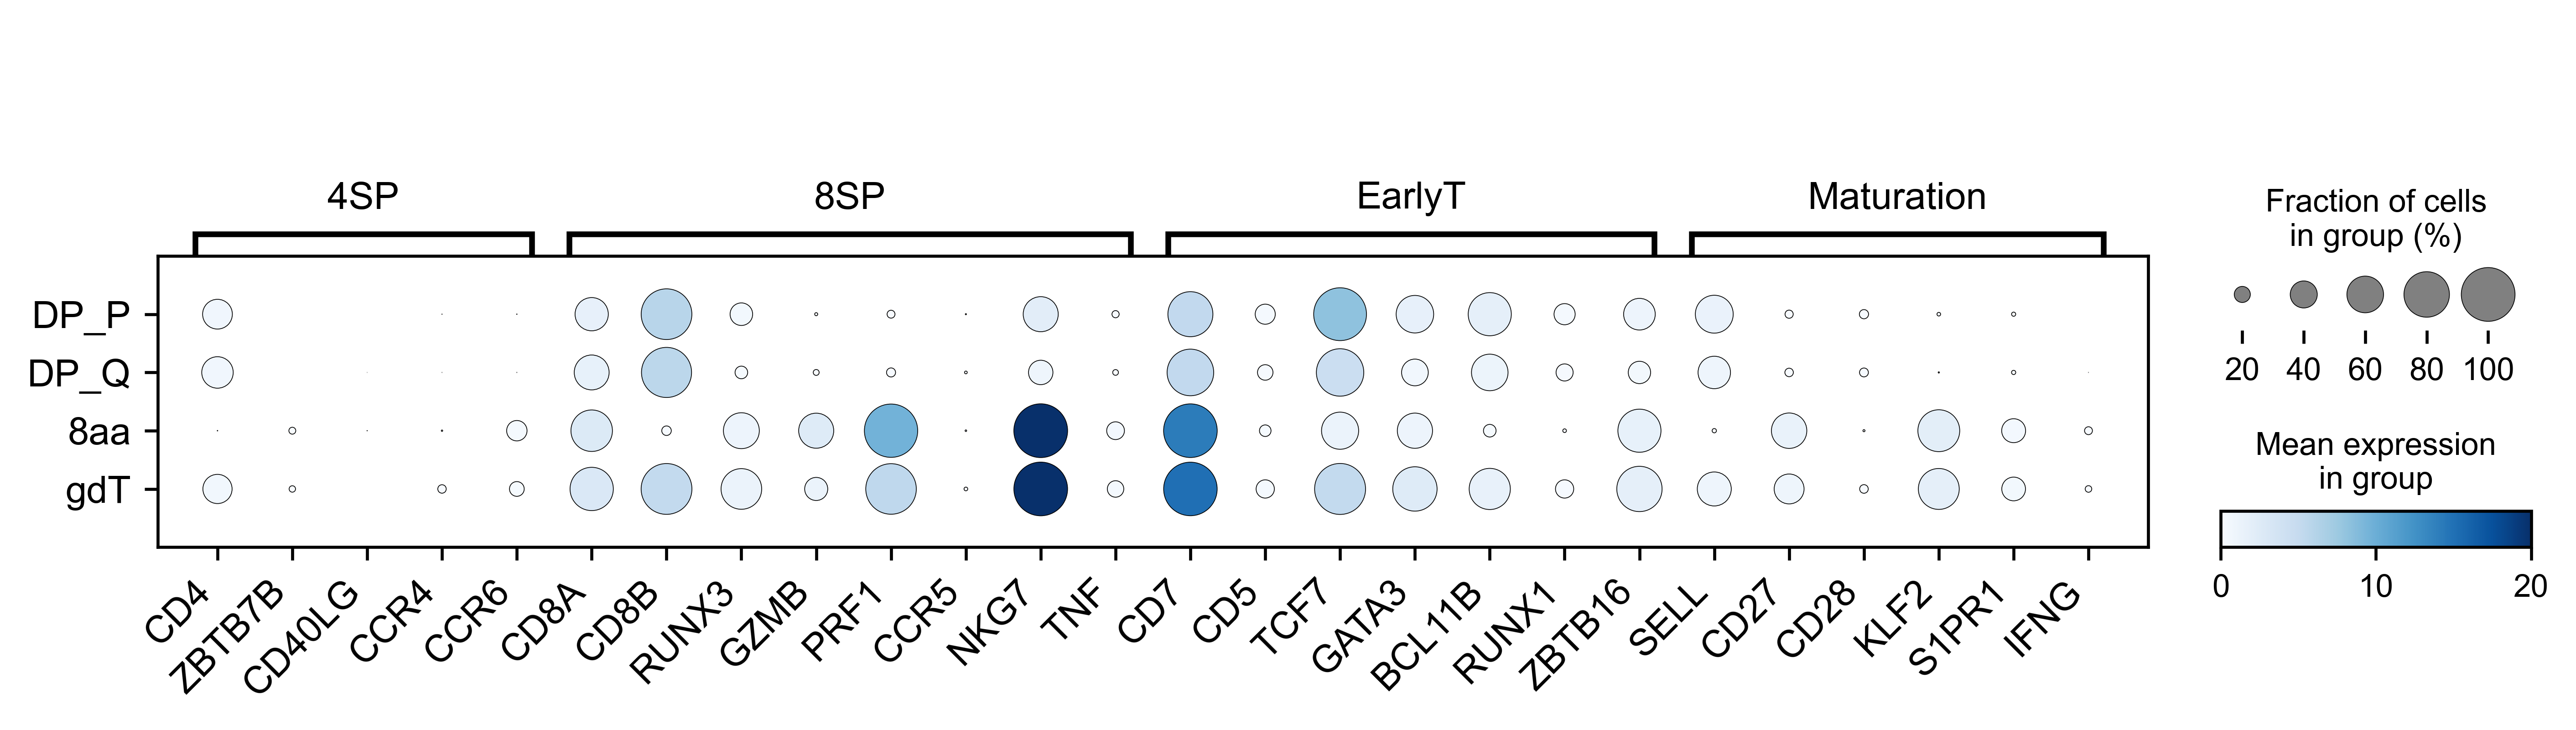

In [ ]:
# Mapping of original → new gene names
gene_rename_dict = {
    "anti-human_CD3": "CD3 (prot)",
    "anti-human_TCR": "TCR (prot)",
    "anti-human_CD4": "CD4 (prot)",
    "anti-human_CD8": "CD8 (prot)",
    "anti-human_CD45RO": "CD45RO (prot)",
    "anti-human_CD45RA": "CD45RA (prot)",
}

adata_temp = adata_subset.copy()
# Apply renaming to .var_names
adata_temp.var_names = adata_temp.var_names.to_series().replace(gene_rename_dict)


genes_top = {
    "Notch": [
        "NOTCH1",
        "NOTCH2",
        "NOTCH3",
        "NOTCH4",
        "DTX1",
        "HES1",
        "HES4",
        "HES5",
        "HEY1",
    ],
    "TCR": [
        # "CD3 (prot)",
        "CD3E",
        "CD3D",
        "RAG1",
        "RAG2",
        "PTCRA",
        # "TCR (prot)",
        "CD69",
        "NR4A1",
        # "TRAC",  # These don't show up
        # "TRBC1",
        # "TRDC1",
        # "TRGC",
    ],
    "Stage Markers": [
        "HIVEP3",  # Ikaros family zinc finger 3 
        "RGPD3",
        "SMPD3",
        "AQP3",
        "RORC",
        "SATB1",
        "TOX2",
        "CCR9",
        "CCR7",
    ],
} # 25

genes_bottom = {
    "4SP": [
        # "CD4 (prot)",
        "CD4",
        "ZBTB7B",
        "CD40LG",
        "CCR4",
        "CCR6",
    ],
    "8SP": [
        # "CD8 (prot)",
        "CD8A",
        "CD8B",
        "RUNX3",
        "GZMB",
        "PRF1",
        "CCR5",
        "NKG7",
        "TNF",
    ],
    "EarlyT": [
        "CD7",
        "CD5",
        "TCF7",
        "GATA3",
        "BCL11B",
        "RUNX1",
        "ZBTB16",
    ],
    "Maturation": [
        "SELL",
        "CD27",
        "CD28",
        "KLF2",
        "S1PR1",
        "IFNG",
        # "CD45RA (prot)",
        # "CD45RO (prot)",
    ],
 } #27


# top_plot_genes_deduped = []

figdp = sc.pl.dotplot(
    adata_temp,
    var_names=genes_top,
    groupby="cell type",
    cmap="Blues",
    vmin=0,
    vmax=20,
    # save=f"_FigS6_citeseq_celltypes-top.{FIG_TYPE}",
    return_fig=True,
)
rotate_labels(figdp)
fig = plt.gcf()
fig.savefig(
    PATH_FIG_DIR / f"dotplot_FigS1_citeseq_celltypes-top.{FIG_TYPE}",
    dpi=DPI_SCALE,
    bbox_inches="tight",
    transparent=True,
)

figdp = sc.pl.dotplot(
    adata_temp,
    var_names=genes_bottom,
    groupby="cell type",
    cmap="Blues",
    vmin=0,
    vmax=20,
    # save=f"_FigS6_citeseq_celltypes-bottom.{FIG_TYPE}",
    return_fig=True,
)
rotate_labels(figdp)
fig = plt.gcf()
fig.savefig(
    PATH_FIG_DIR / f"dotplot_FigS1_citeseq_celltypes-bottom.{FIG_TYPE}",
    dpi=DPI_SCALE,
    bbox_inches="tight",
    transparent=True,
)

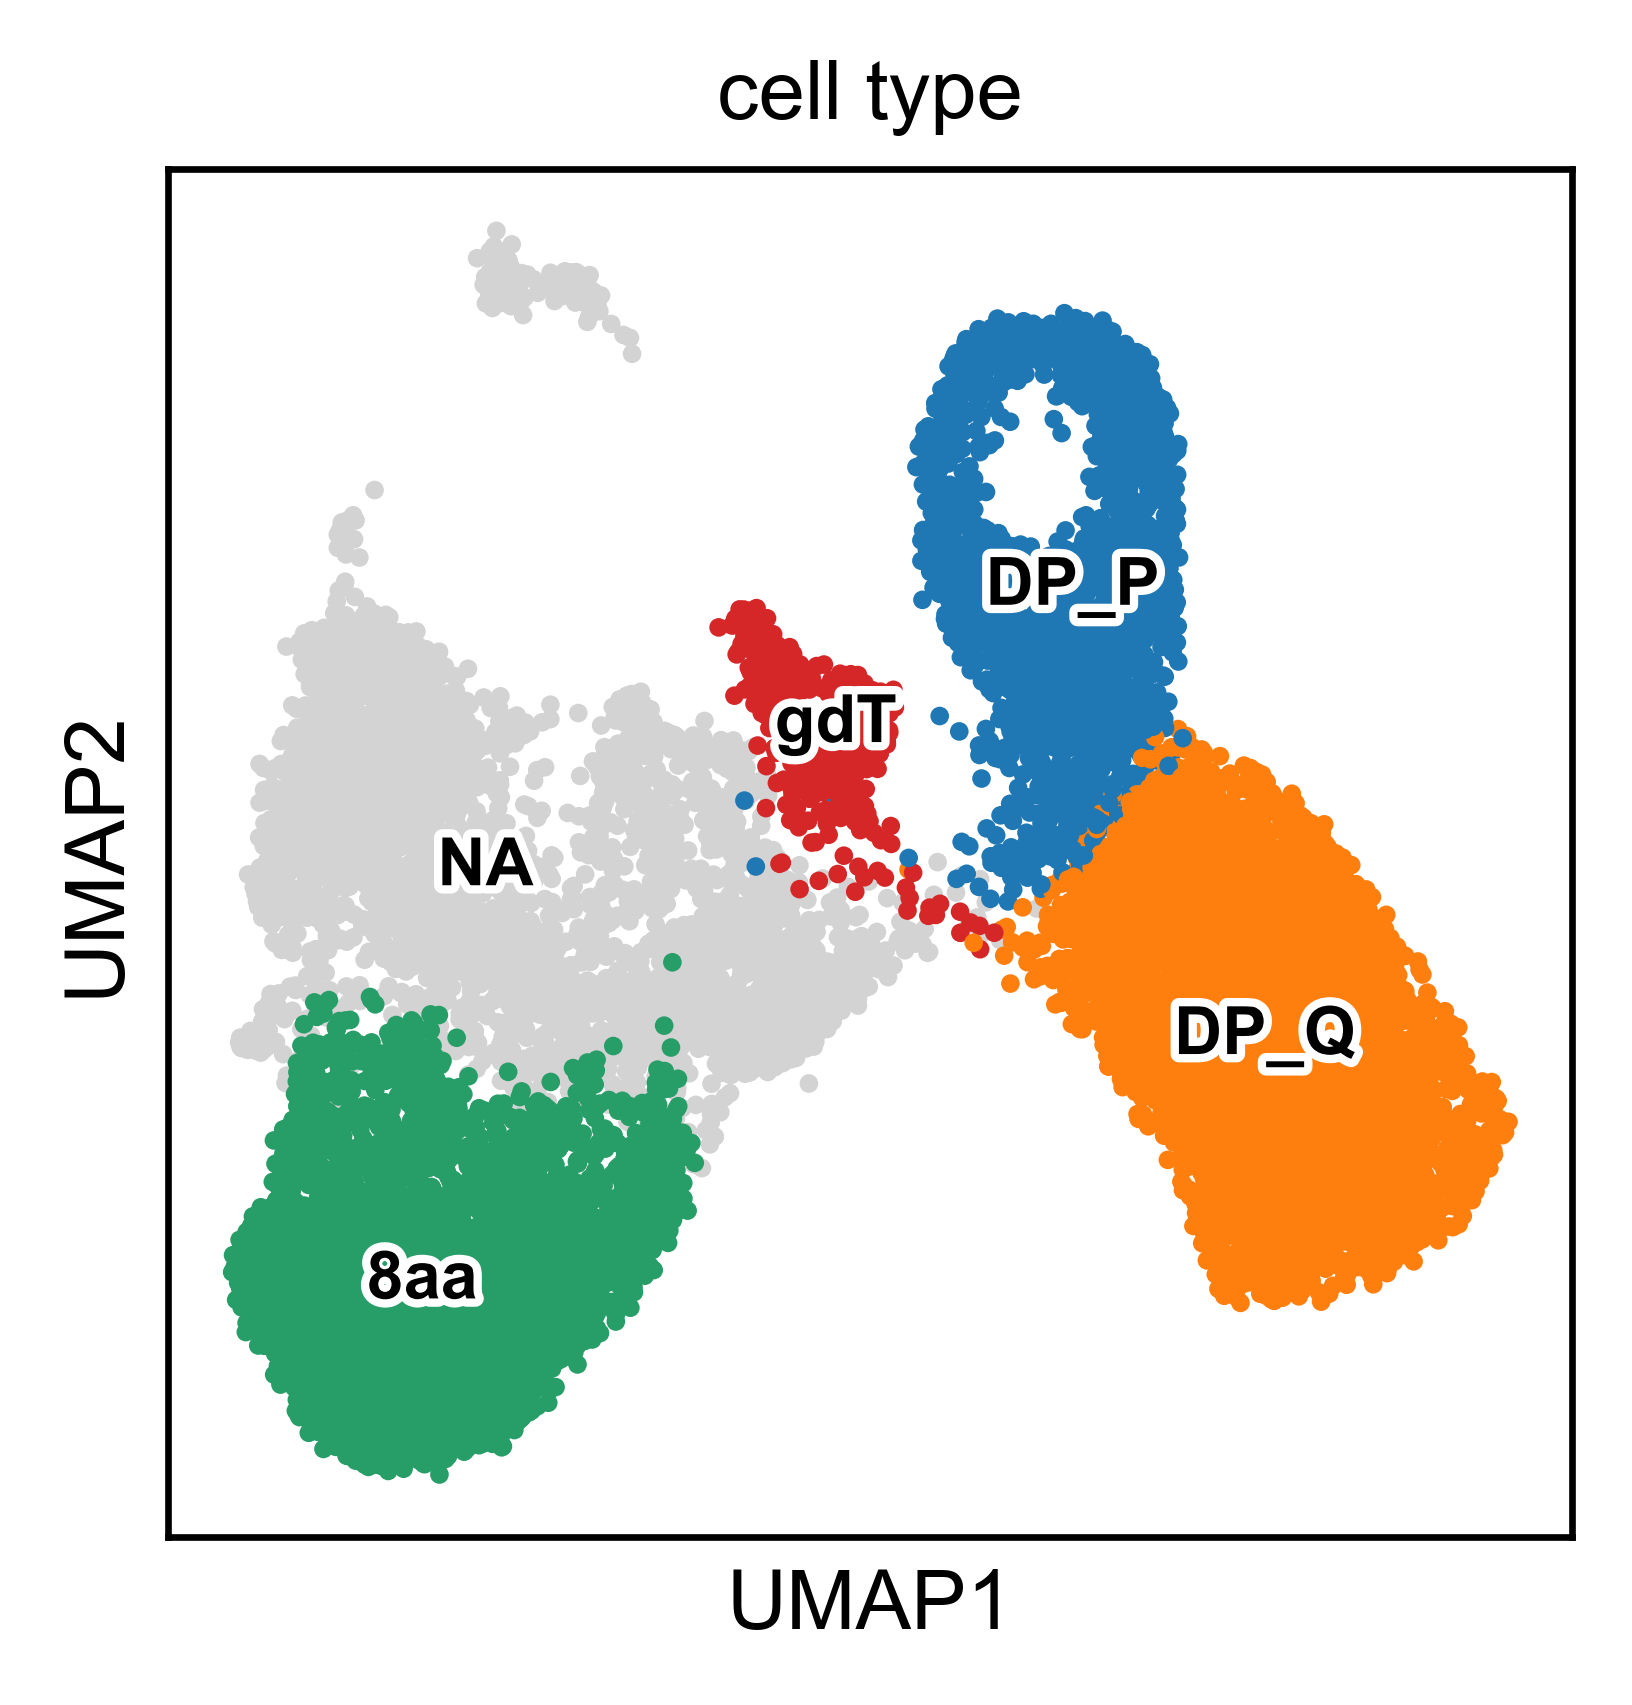

In [26]:
sc.pl.umap(
    adata_subset,
    color=["cell type"],
    size=20,
    legend_loc="on data",
    legend_fontsize=8,
    legend_fontoutline=2,
    # save=f"_FigS1_citeseq_celltypes_renamed.{FIG_TYPE}",
)